In [961]:
# Import the math library for mathematical functions and constants.
import math
# Import the numpy library for numerical operations and array manipulation.
import numpy as np
# Import TensorFlow,for building and training neural networks.
import tensorflow as tf
# Import the pyplot module from the matplotlib library for creating visualizations and plots.
import matplotlib.pyplot as plt
# Import the keras
# s module from TensorFlow, which provides high-level APIs for building and training neural networks.
from tensorflow import keras
# from Quadrilateral import *
from Optimizer1 import *
# from scipy.special import roots_legendre
   

In [962]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [963]:
# Define a class named PlateWithHole that's a subclass of the keras.Model class

class Strip(keras.Model):
    def __init__(self, network_1,network_2 ,dict, X_dom , X_bottom , X_right , X_top, X_left): 
        'above line Defines the parameterized constructor (__init__) of the class "PlateWithHole" which takes several arguments' 
        'for initializing the object '
        super().__init__()
        self.model_1 = network_1 # Assigns the provided network_u to the instance variable model_u.
        self.model_2 = network_2 # Assigns the provided network_v to the instance variable model_v.

        # self.model_u.build(input_shape=(None, 2))
        # self.model_v.build(input_shape=(None, 2))

        # Points
        self.X_dom = X_dom
        self.X_top = X_top
        self.X_bottom = X_bottom
        self.X_left = X_left
        self.X_right = X_right


        # Store history of domain
        self.X_dom_history = []
        self.F_Piola_history = []
        self.S_Piola_history = []
        self.Cauchy_history = []
        self.u_history = []
        self.v_history = []


        # Class Variables to Store Deformation Gradient History
        self.F_domain_old = tf.constant([[1, 0, 0, 1, 1]]).reshape(1,5)
        self.F_Top_old = tf.constant([[1, 0, 0, 1, 1]]).reshape(1,5)
        self.F_Bottom_old = tf.constant([[1, 0, 0, 1, 1]]).reshape(1,5)
        self.F_Left_old = tf.constant([[1, 0, 0, 1, 1]]).reshape(1,5)
        self.F_Right_old = tf.constant([[1, 0, 0, 1, 1]]).reshape(1,5)

        # From dictionary
        self.dict = dict
        self.type = self.dict["type_of_adhesion"]
        self.data_type = self.dict["data_type"]      
        self.E=self.dict["E"]   
        self.nu = self.dict["nu"]
        self.integration_type = self.dict["integration_type"]
        self.Lx = self.dict["Lx"] 
        self.Ly = self.dict["Ly"]
        self.Lx_traction = self.Lx
        self.ns_u = self.dict["ns_u"] 
        self.ns_l = self.dict["ns_l"]

        # Material Parameters ( lame's constant )
        self.mu = self.E/(2*(1+self.nu))
        self.lam = (self.E*self.nu)/((1-2*self.nu)*(1+self.nu))
        self.K=self.E/(3.*(1-2.*self.nu))

        # From previous iteration
        self.u_prev_domain= 0
        self.v_prev_domain= 0
        # self.nansons_ratio_stored = tf.ones((1+self.traction_divisions,1)).astype(self.data_type)

       # Defining here
        self.num_epoch = 30000
        self.tolerance = tf.constant( 1e-15 ,dtype=tf.double)
        self.print_epoch = 100     #Training progress will be printed every 100 epochs if trained with Adam optimizer
        # self.pi_ten = tf.constant([np.pi], dtype= self.data_type)  #assign the value of pi
        
 
    # Define a function to compute the u displacement field
    # @tf.function # Decorator provided by TensorFlow that converts the annotated Python function (u in this case) into a TensorFlow graph
    def u(self, X):
        x=X[:,0:1]
        X1 = self.model_1(X)    # Pass the input tensor X through the neural network model model_u to compute the output (U)
        return X1*x      #Imposing exact displacement boundary condition for u ( displacement in x direction) 
    
    # Define a function to compute the v displacement field
    def v(self, X):
        y=X[:,1:2]
        X1 = self.model_2(X)   # pass the input tensor X through the neural network model model_v to compute the output (V)
        return X1*y
    
    # def nansons_ratio(self, X):
    #     X1 = self.model_2(X)   # pass the input tensor X through the neural network model model_v to compute the output (V)
    #     return X1[:,0:1]
    
    def call(self, X):
        uVal = self.u(X)    # Calling u function
        vVal = self.v(X)    # Calling v function
        disp = tf.concat([uVal, vVal], axis=1) # horizontally stacking uVal and vVal 
        return disp

    # Define a function to calculate deformation gradient
    
    
    def deform_grad(self,x,y,num):
        with tf.GradientTape(persistent=True) as g: #creates a gradient tape that records operations for automatic differentiation
            g.watch(x)
            g.watch(y)
            X=tf.concat([x, y],axis=1)
            U = self.u(X) #get u
            V = self.v(X) #get v
        u_x = g.gradient(U, x)  #du/dx
        v_y = g.gradient(V, y)  #dv/dy
        u_y = g.gradient(U, y)  #du/dy
        v_x = g.gradient(V, x)  #dv/dx
        del g
        #shape function part starts here
        
            #jacobian between current configuration and master element
           
        #shape function part ends here
        if(num =='Domain'):
            F11_old , F12_old , F21_old , F22_old   = self.F_domain_old[:,0:1],self.F_domain_old[:,1:2],self.F_domain_old[:,2:3],self.F_domain_old[:,3:4]
        elif(num =='Top'):
            F11_old , F12_old , F21_old , F22_old  = self.F_Top_old[:,0:1],self.F_Top_old[:,1:2],self.F_Top_old[:,2:3],self.F_Top_old[:,3:4] 
        elif(num =='Left'):
            F11_old , F12_old , F21_old , F22_old  = self.F_Left_old[:,0:1],self.F_Left_old[:,1:2],self.F_Left_old[:,2:3],self.F_Left_old[:,3:4]
        elif(num =='Bottom'):
            F11_old , F12_old , F21_old , F22_old = self.F_Bottom_old[:,0:1],self.F_Bottom_old[:,1:2],self.F_Bottom_old[:,2:3],self.F_Bottom_old[:,3:4]
        elif(num =='Right'):
            F11_old , F12_old , F21_old , F22_old  = self.F_Right_old[:,0:1],self.F_Right_old[:,1:2],self.F_Right_old[:,2:3],self.F_Right_old[:,3:4]

        F11 = (F11_old * (1 + u_x)) + (F21_old * (u_y))
        F12 = (F12_old*(1 + u_x))   + (F22_old * (u_y))
        F21 = (v_x * F11_old) + ((1 + v_y) * F21_old)  
        F22 = (v_x * F12_old) + ((1 + v_y) * F22_old)  
        
        detF = tf.math.abs(F11*F22 - F12*F21)

        return tf.concat([F11, F12, F21, F22 , detF] ,axis=1)

    
    # Compute the First Piola Kirchoff stresses
    # @tf.function
    def FPiolaKirchoff(self, x, y,num):

        D_grad= self.deform_grad(x, y, num)
        F11, F12, F21, F22 , detF = D_grad[:,0:1] , D_grad[:,1:2] , D_grad[:,2:3], D_grad[:,3:4], D_grad[:,4:5]        
        
        invF11 = F22 / detF
        invF12 = -F12 / detF
        invF21 = -F21 / detF
        invF22 = F11 / detF

        P11 = (self.mu * F11) + (( self.lam * tf.math.log(detF) - self.mu ) * invF11)
        P12 = (self.mu * F12) + (( self.lam * tf.math.log(detF) - self.mu ) * invF21)
        P21 = (self.mu * F21) + (( self.lam * tf.math.log(detF) - self.mu ) * invF12)
        P22 = (self.mu * F22) + (( self.lam * tf.math.log(detF) - self.mu ) * invF22)

        return tf.concat([P11,P12,P21,P22] ,axis=1)

    # @tf.function
    def Second_PiolaK_kirchoff(self, x, y,num):

        D_grad= self.deform_grad(x, y,num)
        F11, F12, F21, F22 , detF = D_grad[:,0:1] , D_grad[:,1:2] , D_grad[:,2:3], D_grad[:,3:4], D_grad[:,4:5]

        F_Piola = self.FPiolaKirchoff(x, y , num)
        P11, P12, P21, P22 = F_Piola[:,0:1],F_Piola[:,1:2],F_Piola[:,2:3],F_Piola[:,3:4]

        invF11 = F22 / detF
        invF12 = -F12 / detF
        invF21 = -F21 / detF
        invF22 = F11 / detF

        S11 = invF11 * P11 + invF12 * P21
        S12 = invF11 * P12 + invF12 * P22
        S21 = invF21 * P11 + invF22 * P21
        S22 = invF21 * P12 + invF22 * P22

        return tf.concat([S11, S12, S21, S22] ,axis=1)

    # Compute the Cauchy's stress tensor, S = P*(F^T)/J
    def CauchyStress(self, x, y,num):
        D_grad= self.deform_grad(x, y,num)
        F11, F12, F21, F22 , detF = D_grad[:,0:1] , D_grad[:,1:2] , D_grad[:,2:3], D_grad[:,3:4], D_grad[:,4:5]
        F_Piola = self.FPiolaKirchoff(x, y , num)
        P11, P12, P21, P22 = F_Piola[:,0:1],F_Piola[:,1:2],F_Piola[:,2:3],F_Piola[:,3:4]

        sig_11 = (P11*F11 + P12*F12)/detF
        sig_12 = (P11*F21 + P12*F22)/detF
        sig_21 = (P21*F11 + P22*F12)/detF
        sig_22 = (P21*F21 + P22*F22)/detF

        return tf.concat([sig_11,sig_12,sig_21,sig_22] ,axis=1)
    
    # def von_mises(self,x,y,num):
    #     S11, S12, S21, S22 = self.Second_PiolaK_kirchoff(x, y,num)
    #     SVonMises = np.sqrt(0.5 * ((S11 - S22) ** 2 + (S22) ** 2 + (-S11) ** 2 + 6 * (S12 ** 2)))
    #     return SVonMises

    def getEnergy(self,x,y,num):
        
        x = tf.convert_to_tensor(x)
        y = tf.convert_to_tensor(y)
        X=tf.concat([x, y],axis=1)
        c10= self.mu / 2
        d1=2./self.K
        N_element=(self.ns_l-1)*(self.ns_u-1)
        dx=self.Lx/(self.ns_u-1)
        dy=self.Ly/(self.ns_l-1)
        u_pred = tf.convert_to_tensor(self.u(X))
        v_pred= tf.convert_to_tensor(self.v(X))
        #UV_pred=tf.concat([u_pred,v_pred],axis=1)
        order=[1 , self.ns_u, self.ns_l]
        Ux = tf.transpose(tf.reshape(u_pred, order), perm=[0, 2, 1])
        Uy = tf.transpose(tf.reshape(v_pred, order), perm=[0, 2, 1])
        U=tf.concat([Ux,Uy],axis=0) 
        U_N1=U[:,:-1,:-1]
        U_N2=U[:,:-1,1:]
        U_N3=U[:,1:,1:]
        U_N4=U[:,1:,:-1]
        
        # Assuming U_N1, U_N2, ..., U_N8 are TensorFlow tensors
        U_N = tf.stack([U_N1, U_N2, U_N3, U_N4])
        detJ=dx*dy*0.25
        Jinv=np.zeros([2,2])
        dxdy=[dx,dy]
        for i in range(2):
            Jinv[i,i]=2/dxdy[i]
        Jinv=tf.convert_to_tensor(Jinv)
        identity=tf.eye(2,dtype=tf.double)
        strainEnergy_at_elem=tf.zeros(N_element)
        vv=np.sqrt(1./3.)
        pt=[-vv,vv]
        intpt=tf.constant([[pt[0],pt[0]],
                         [pt[1],pt[0]],
                        [pt[1],pt[1]],
                        [pt[0],pt[1]]],dtype=tf.double)
        for i in range(4):
            zeta=intpt[i,0]
            eta=intpt[i,1]
            B=tf.convert_to_tensor([[(eta-1)*0.25,(zeta-1)*0.25],
                            [(1-eta)*0.25,-(zeta+1)*0.25],
                            [(1+eta)*0.25,(1+zeta)*0.25],
                            [-(eta+1)*0.25,(1-zeta)*0.25]],dtype=tf.double)
            B_physical=tf.matmul(B,Jinv)
            dUx=tf.einsum('ijk,iq->qjk',U_N[:,0,:,:],B_physical)
            dUy=tf.einsum('ijk,iq->qjk',U_N[:,1,:,:],B_physical)
            # print("Okay till here")
            concatenated = tf.concat([dUx, dUy], axis=0)
            #flattened=tf.flatten(concatenated,start_dim=1,end_dim=-1)
            flattened = tf.reshape(concatenated, [concatenated.shape[0], -1])
            transposed = tf.transpose(flattened, perm=[1, 0])
            grad_u = tf.reshape(transposed, [N_element, 2, 2])
            #grad_u=tf.reshape((tf.flatten(tf.concatenate([dUx,dUy],dim=0),start_dim=1,end_dim=-1).transpose(0,1)),[N_element,2,2])
            F=identity+grad_u
            detF=tf.linalg.det(F)
            print("detF",detF)
            F_bar=tf.einsum('qij,q->qij',F,1/tf.sqrt(detF))
            C=tf.einsum('qij,qik->qjk',F_bar,F_bar)
            I1=tf.einsum('qii->q',C)
            psiE=c10*(I1-2.)+((detF-1)**2)/d1
            strainEnergy_at_elem+=psiE*detJ
        
        return tf.reduce_sum(strainEnergy_at_elem)     
    
    def quantity(self,X_bottom):
        traction_y = 0
        traction_x = 0
        quantity = ((self.u(X_bottom) + X_bottom[:,0:1]) * traction_x) + ((self.v(X_bottom) + X_bottom[:,1:2]) * traction_y ) # 
        return quantity

    # def integral_1D(self):
    #     N = self.traction_divisions   # Number of divisions
    #     a, b = 0 , self.Lx_traction
    #     h = (b - a) / N

    #     if(self.integration_type=='trapezoidal'):      
    #         # Initialize the integral approximation
    #         integral_approximation = 0.5 *  (self.quantity(self.X_bottom_trac_1[0:1,:]) + self.quantity(self.X_bottom_trac_1[-1:,:]) ) 
            
    #         integral_approximation += tf.reduce_sum(self.quantity(self.X_bottom_trac_1[1:-1,:]))
    #         integral_approximation *= h
        
    #     elif(self.integration_type=='simpsons'):    
    #         integral_approximation = (self.quantity(self.X_bottom_trac_1[0:1,:]) + self.quantity(self.X_bottom_trac_1[-1,:].reshape(1,2)))

    #         # Calculate the sum using Simpson's rule
    #         weights = np.ones((N - 1, 1)).astype(self.data_type)
    #         weights[1::2] = 4
    #         weights[2::2] = 2
    #         integral_approximation += tf.reduce_sum(weights * self.quantity(self.X_bottom_trac_1[1:-1,:]))
    #         integral_approximation *= h / 3.0

    #     elif self.integration_type == 'gaussian':
    #         """
    #         Compute the integral of a function using Gauss quadrature.

    #         Parameters:
    #             func (function): The function to integrate.
    #             a (float): Lower limit of integration.
    #             b (float): Upper limit of integration.
    #             n (int): Number of quadrature points.

    #         Returns:
    #             float: The approximate value of the integral.
    #         """
    #         # Calculate the nodes and weights using NumPy's built-in function
    #         n = 10 # number of gauss quadrature points
    #         zeta, weight = np.polynomial.legendre.leggauss(n)

    #         # Rescale nodes and weights to the interval [a, b]
    #         x_mapped = 0.5 * (b - a) * zeta + 0.5 * (b + a)
    #         w_mapped = 0.5 * (b - a) * weight

    #         x_mapped = x_mapped.reshape(-1,1)
    #         w_mapped = w_mapped.reshape(-1,1)
    #         col2 = tf.zeros((n,1)).astype(self.data_type)
    #         Array = tf.concat([x_mapped,col2],axis=1)

    #         # Evaluate the function at the mapped nodes and sum up
    #         integral_approximation = tf.reduce_sum(w_mapped * self.quantity(Array))

    #     return integral_approximation

    # @tf.function
    def integral_2D(self,num):

        a, b, c, d = 0, self.Lx, 0, self.Ly
        N, M = self.ns_u,self.ns_l

        delta_x = (b - a) / (N-1)
        delta_y = (d - c) / (M-1)

        points = self.X_dom

        if(self.integration_type=='trapezoidal'):
           
            weights = np.ones(points.shape)
            weights[1:-1, :] = 2
            weights[:, 1:-1] = 2
            weights[0, 0] = weights[0, -1] = weights[-1, 0] = weights[-1, -1] = 1
            
            integral_approximation = tf.reduce_sum(weights * self.getEnergy(points[:, 0:1], points[:, 1:2],num))
            #integral_approximation *= 0.25 * delta_x * delta_y

        elif(self.integration_type=='simpsons'):
            weights = np.ones(points.shape)
            weights[1:-1, :] = 4
            weights[:, 1:-1] = 4
            weights[1:-1, 1:-1] = 16
            weights[0, :] = weights[-1, :] = weights[:, 0] = weights[:, -1] = 1

            integral_approximation = tf.reduce_sum(weights * self.getEnergy(points[:, 0:1], points[:, 1:2],num))
            integral_approximation *= (delta_x * delta_y) / (1.9911938832103648)
        
        elif self.integration_type =='gaussian' :
        
            Lx=self.Lx
            Ly=self.Ly

            Ny=7
            Nx=7
            Nele = Nx*Ny

            del_Lx = Lx/Nx
            del_Ly = Ly/Ny

            nx = 20 # Number of quadrature points in the x-direction
            ny = 20 # Number of quadrature points in the y-direction

            # Calculate the nodes and weights using NumPy's built-in function
            zeta, weights_z = np.polynomial.legendre.leggauss(nx)
            eta, weights_e = np.polynomial.legendre.leggauss(ny)

            # Initialize the connectivity list properly
            connectivity = []

            # Create the 2D list
            for j in range(Ny):
                for i in range(Nx):
                    connectivity.append([del_Lx * i, del_Lx * (i + 1), del_Ly * j, del_Ly * (j + 1)])

            # Convert connectivity to NumPy array for efficiency
            connectivity = np.array(connectivity)

            integral_approximation = 0.0

            def integral_fn(a, b, c, d, zeta, weights_z, eta, weights_e):
                # Rescale nodes and weights to the interval [a, b] and [c, d] respectively
                x_mapped = 0.5 * (b - a) * zeta + 0.5 * (b + a)
                y_mapped = 0.5 * (d - c) * eta + 0.5 * (d + c)
                wx_mapped = 0.5 * (b - a) * weights_z
                wy_mapped = 0.5 * (d - c) * weights_e

                # Generate Array tensor
                X, Y = tf.meshgrid(x_mapped, y_mapped)
                Array = tf.stack([tf.reshape(X, (-1,)), tf.reshape(Y, (-1,))], axis=1)

                # Compute energy using pred_model
                energy = self.getEnergy(Array[:, 0:1], Array[:, 1:2], "Domain")
                
                # Reshape energy tensor to match the shape of wx_mapped and wy_mapped
                energy = tf.reshape(energy, (nx, ny))

                # Perform integral approximation
                integral = tf.reduce_sum(wx_mapped[:, tf.newaxis] * wy_mapped * energy)
                return integral


            # Iterate over each element for integral calculation
            for i in range(Nele):
                a, b, c, d = connectivity[i]
                integral_approximation += integral_fn(a, b, c, d, zeta, weights_z, eta, weights_e)

        return integral_approximation
            
    # @tf.function
    def update_attributes(self,num):
        if(num != 0):
            X_dom=self.X_dom
            X_top=self.X_top
            X_bottom=self.X_bottom
            X_left=self.X_left
            X_right=self.X_right

            self.u_prev_domain = self.u_prev_domain + self.u(X_dom)
            self.v_prev_domain = self.v_prev_domain + self.v(X_dom)

            Cauchy =self.CauchyStress(X_dom[:,0:1],X_dom[:,1:2],"Domain")
            F_Piola =self.FPiolaKirchoff(X_dom[:,0:1],X_dom[:,1:2],"Domain")
            S_Piola =self.Second_PiolaK_kirchoff(X_dom[:,0:1],X_dom[:,1:2],"Domain")

            self.Cauchy_history.append(Cauchy)
            self.F_Piola_history.append(F_Piola)
            self.S_Piola_history.append(S_Piola)
            self.X_dom_history.append(X_dom)
            self.u_history.append(self.u_prev_domain)
            self.v_history.append(self.v_prev_domain)
            
            # Update F variables 
            self.F_domain_old = self.deform_grad(X_dom[:,0:1],X_dom[:,1:2],"Domain")
            self.F_Left_old = self.deform_grad(X_left[:,0:1],X_left[:,1:2],"Left")
            self.F_Right_old = self.deform_grad(X_right[:,0:1],X_right[:,1:2],"Right")
            self.F_Top_old = self.deform_grad(X_top[:,0:1],X_top[:,1:2],"Top")
            self.F_Bottom = self.deform_grad(X_bottom[:,0:1],X_bottom[:,1:2],"Bottom")

            X_dom = tf.concat([self.X_dom[:, 0:1] + self.u(self.X_dom), self.X_dom[:, 1:2] + self.v(self.X_dom)], axis=1)
            X_top = tf.concat( [self.X_top[:,0:1] + self.u(self.X_top) ,self.X_top[:,1:2] + self.v(self.X_top)],axis=1)
            X_bottom = tf.concat( [self.X_bottom[:,0:1] + self.u(self.X_bottom) ,self.X_bottom[:,1:2] + self.v(self.X_bottom)],axis=1)
            X_left = tf.concat([self.X_left[:,0:1]  + self.u(self.X_left) ,self.X_left[:,1:2] + self.v(self.X_left)],axis=1)
            X_right =tf.concat( [self.X_right[:,0:1] + self.u(self.X_right) ,self.X_right[:,1:2] + self.v(self.X_right)],axis=1)

            self.X_dom=X_dom
            self.X_top=X_top
            self.X_bottom=X_bottom
            self.X_left=X_left
            self.X_right=X_right


    def sigmoid_with_constant(self,x, constant):
        return 1 / (1 + tf.exp(constant * x))
    

    #@tf.function
    def loss_all(self, num, disp ):
    
        X_dom=self.X_dom
        X_top=self.X_top
        X_bottom=self.X_bottom
        X_left=self.X_left
        X_right=self.X_right

        # Getting potential energy loss        
        Integration_1 = self.integral_2D("Domain")
        # Integration_2 = self.integral_1D()
        Net = Integration_1 #- Integration_2
        print(f"internal energy{Net}")
        print("Shape",Net.shape)
        #print("internal energy",Net)
        loss_domain1 = tf.math.square(Net-0)  
        #print(f"loss domain{loss_domain1}")

        # Loss for boundary conditions
        v_t = self.v(X_top)                  
        u_l = self.u(X_left)
        v_b = self.v(X_bottom) 
        loss_boundary_D1= tf.reduce_sum(tf.math.square(v_t - disp))#+tf.math.square(v_b-0)+tf.math.square(u_l -0))          
        #print(f"Loss boundary{loss_boundary_D1}")   
        return  loss_domain1 , loss_boundary_D1 * 100

    #@tf.function
    def loss_grad(self,num, disp ):
        with tf.GradientTape() as g: #creates a gradient tape that records operations for automatic differentiation
            #g.watch(self.trainable_variables) # line tells the gradient tape to watch the trainable variables (model parameters) so that it can later compute gradients with respect to them.
            loss_domain , loss_boundary_D = self.loss_all(num ,disp)
            losses=  loss_domain + loss_boundary_D 
        grad = g.gradient(losses, self.trainable_variables) #computes the gradients of the total loss with respect to the trainable variable
        return  loss_domain , loss_boundary_D, grad

    
    def train(self,num,disp):
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)# initializes an Adam optimizer ,optimizer will be used to update the model parameters during training.
        tolerance = 0.0001
        patience = 30
        best_loss = float('inf')
        no_improvement_epochs = 0
        for epoch in range(self.num_epoch):
            print("Epoch:", epoch + 1)
            with tf.GradientTape() as tape:
                loss_domain , loss_boundary_D1 = self.loss_all(num, disp)
                loss_val =  loss_domain + loss_boundary_D1 
            grads = tape.gradient(loss_val, self.trainable_variables)
            #  Below line applies the computed gradients to update the trainable variables using the optimizer.
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
            if loss_val < best_loss - tolerance:
                best_loss = loss_val
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1
    
    # Early stopping
            if no_improvement_epochs >= patience:
                print(f"Stopping early at epoch {epoch}")
                print(f"Epoch {epoch}, Loss: {loss_val.numpy()}")
                break
            if (epoch + 1) % self.print_epoch == 0:
                print("Epoch:", epoch + 1, " Loss:", loss_val.numpy())  # print loss and epochs

    def Stepped_training_Adam(self, U , steps):
        du = U/steps
        for num in range(steps):
            disp = du
            print(f" For step={num+1} and value of u={du*(1+num) }")
            #trac = self.traction(num)
            #print(f"Value of traction is {trac}")
            self.train(num, disp)  #Train the pred_model

    def Stepped_training_LBFGS(self,U,steps):
        du = U/steps
    
        for num in range(steps):
            disp = du
            print(f" For step={num+1} and value of u={du*(1+ num ) }")
            self.update_attributes(num)
            l_bfgs_b = Opt_lbfgsb(self, num , disp)
            result = l_bfgs_b.fit()
            if(num == steps-1):
                self.update_attributes(num)



In [964]:

# Normalization Parameters
Lo=1
Eo=1
## domain points
my_dict={}
my_dict["type_of_adhesion"]='strong'                     # Give strong or weak as input
my_dict["data_type"]='float64'                           # float32 or float64
my_dict["E"]=Eo/(Lo**3)
my_dict["num_iteration_LBFGS"]=1000
my_dict["nu"]= 0.2                                       # Poissons Ratio
my_dict["Lx"]= 10*Lo                                    # Length in x-direction
my_dict["Ly"]= 10*Lo                                     # Length in y-direction
my_dict["integration_type"]='trapezoidal'           #    'simpsons'         'trapezoidal'  

tf.keras.backend.set_floatx(my_dict["data_type"])        # Set the default float type for Keras backend

# Create the keras sequential models for u and v separately
network_u = keras.Sequential([
    keras.layers.Input(shape=(2,)),  
    keras.layers.Dense(15, activation='tanh'),
    keras.layers.Dense(15, activation='tanh'),
    keras.layers.Dense(15, activation='tanh'),
    keras.layers.Dense(1)
])

network_v = keras.Sequential([
    keras.layers.Input(shape=(2,)),  
    keras.layers.Dense(15, activation='tanh'),
    keras.layers.Dense(15, activation='tanh'),
    keras.layers.Dense(15, activation='tanh'),
    keras.layers.Dense(1)
])

In [965]:
data_type = my_dict["data_type"]
Lx = my_dict["Lx"]
Ly = my_dict["Ly"]  

# Creating domain points mesh
dx=0.2                     # x_spacing 
dy=0.2                     # y_spacing
ns_u = int(1 + (Lx/dx))       # Number of points in x direction = 51
ns_l = int(1 + (Ly/dy))       # Number of points in x direction = 51

my_dict["ns_u"] = ns_u                             # Length in x-direction
my_dict["ns_l"] = ns_l

In [966]:
print(ns_u,ns_l)

51 51


In [967]:


xy = np.zeros((ns_u*ns_l, 2)).astype(data_type)
k = 0
for i in range(0,ns_u):
    for j in range(0,ns_l):
            xy[k, 0] = i * dx
            xy[k, 1] = j * dy
            k = k+1

x_domain = xy
X_dom = tf.convert_to_tensor(x_domain,dtype=data_type) 

# Creating top edge points
x_u = np.linspace(0,Lx, 101).reshape(-1, 1).astype(data_type)
y_u = (Ly)*np.ones((101,1)).astype(data_type)
X_top=np.hstack([x_u,y_u])
X_top = tf.convert_to_tensor(X_top,dtype=data_type) 

# Creating bottom edge with traction points 
x_b = np.linspace(0,Lx,101).reshape(-1, 1).astype(data_type)
y_b = np.zeros((101,1)).astype(data_type)
X_bottom = np.hstack([x_b,y_b])
X_bottom = tf.convert_to_tensor(X_bottom,dtype=data_type) 

# Creating left edge points 
x_l = np.zeros((101,1)).astype(data_type)
y_l = np.linspace(0,Ly, 101).reshape(-1, 1).astype(data_type)
X_left=np.hstack([x_l,y_l])
X_left = tf.convert_to_tensor(X_left,dtype=data_type) 

# Creating right edge points 
x_r = Lx * np.ones((101,1)).astype(data_type)
y_r = np.linspace(0,Ly, 101).reshape(-1, 1).astype(data_type)
X_right=np.hstack([x_r,y_r])
X_right = tf.convert_to_tensor(X_right,dtype=data_type) 

In [968]:
x_domain.shape

(2601, 2)

In [969]:
pred_model = Strip( network_u,network_v, my_dict ,  X_dom , X_bottom , X_right , X_top, X_left)

In [970]:
U = -0.5
steps=1

In [971]:
# pred_model.update_attributes(1)

In [973]:
# Save weights
#pred_model.save_weights('HE_DEM_new_u=-0.5_step=1.weights.h5')
# Load Weights
pred_model.load_weights('HE_DEM_trapezoidalSF_u=-0.5_step=1.weights.h5')

In [ ]:
# for i in range(30):
#     pred_model.Stepped_training_Adam(U,steps)
    #pred_model.Stepped_training_LBFGS(U,steps)
pred_model.Stepped_training_Adam(U,steps)

 For step=1 and value of u=-0.5
Epoch: 1
detF tf.Tensor(
[ 1.027323    1.00471679  0.92876412 ... -0.0605343  -0.09673371
 -0.11664458], shape=(2500,), dtype=float64)
detF tf.Tensor(
[ 0.93847475  0.90943768  0.83691808 ... -0.07840623 -0.10470253
 -0.1151186 ], shape=(2500,), dtype=float64)
detF tf.Tensor(
[ 0.94808744  0.920298    0.85000506 ... -0.07318201 -0.09854832
 -0.10713259], shape=(2500,), dtype=float64)
detF tf.Tensor(
[ 1.03693569  1.01557712  0.94185109 ... -0.05531007 -0.0905795
 -0.10865858], shape=(2500,), dtype=float64)
internal energynan
Shape ()
Epoch: 2
detF tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(2500,), dtype=float64)
detF tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(2500,), dtype=float64)
detF tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(2500,), dtype=float64)
detF tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(2500,), dtype=float64)
internal energynan
Shape ()


2024-08-30 11:27:17.507074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input is not invertible.


InvalidArgumentError: {{function_node __wrapped__MatrixInverse_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is not invertible. [Op:MatrixInverse] name: 

In [974]:
x_domain=pred_model.X_dom
# x_domain=pred_model.X_dom_history[0]

X = x_domain[:, 0:1]  # Extract x-coordinates as a 2D column array
Y = x_domain[:, 1:2]  # Extract y-coordinates as a 2D column array

# # Predicted Stresses
Piola = pred_model.FPiolaKirchoff(X,Y,"Domain")
P11, P12, P21, P22 = Piola[:,0:1],Piola[:,1:2],Piola[:,2:3],Piola[:,3:4]

Cauchy = pred_model.CauchyStress(X,Y,"Domain")
S11,S12,S21,S22= Cauchy[:,0:1],Cauchy[:,1:2],Cauchy[:,2:3],Cauchy[:,3:4]

# Predicted Displacement
predicted_displacement = pred_model(x_domain)
x_disp = predicted_displacement[:, 0:1]  # Extract x-displacements as a 2D column array
y_disp = predicted_displacement[:, 1:2]  # Extract y-displacements as a 2D column array

x1= X + x_disp
y1= Y + y_disp

X=x1
Y=y1

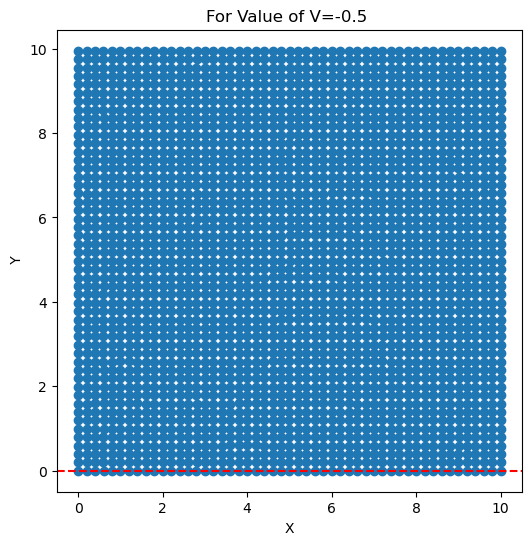

In [975]:


# Create a figure with custom dimensions (e.g., 8 inches wide and 6 inches tall)
plt.figure(figsize=(6, 6))
plt.scatter(X,Y)
# Set y-axis limits
# plt.ylim(None, 15*Lo)

# plt.axhline(y=0,color='red', linestyle='--', label='y=ro')
plt.axhline(y=0, color='red', linestyle='--', label='y=0.4')

plt.title(f"For Value of V={-0.5} ")
plt.xlabel("X")
plt.ylabel(" Y")
plt.show()


In [976]:
ylimit = Ly

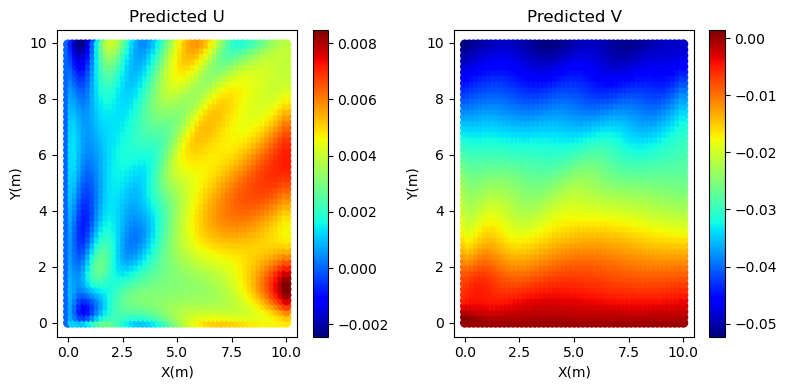

In [977]:
# Create a single figure
# from matplotlib.colors import LinearSegmentedColormap

plt.figure(figsize=(8, 4))

# Subplot 1
plt.subplot(1, 2, 1)  # 4 rows, 1column, subplot 1
scatter = plt.scatter(X,Y,c=x_disp+pred_model.u_prev_domain, cmap='jet', s=50, edgecolors='k', linewidths=0)
# ,vmin=0,vmax=0.07
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
# plt.ylim(None, ylimit)

plt.title('Predicted U')
plt.colorbar(scatter)

# Subplot 2
plt.subplot(1, 2, 2)  # 4 rows, 1 column, subplot 2
scatter = plt.scatter(X, Y,c=y_disp+pred_model.v_prev_domain,cmap='jet',s=50, edgecolors='k', linewidths=0.0000)
# ,vmax=0,vmin=-0.2
# ,vmin=-0.2,vmax=0
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
# plt.ylim(None, ylimit)

plt.title('Predicted V')
plt.colorbar(scatter)

plt.tight_layout()

variation of sigma-x


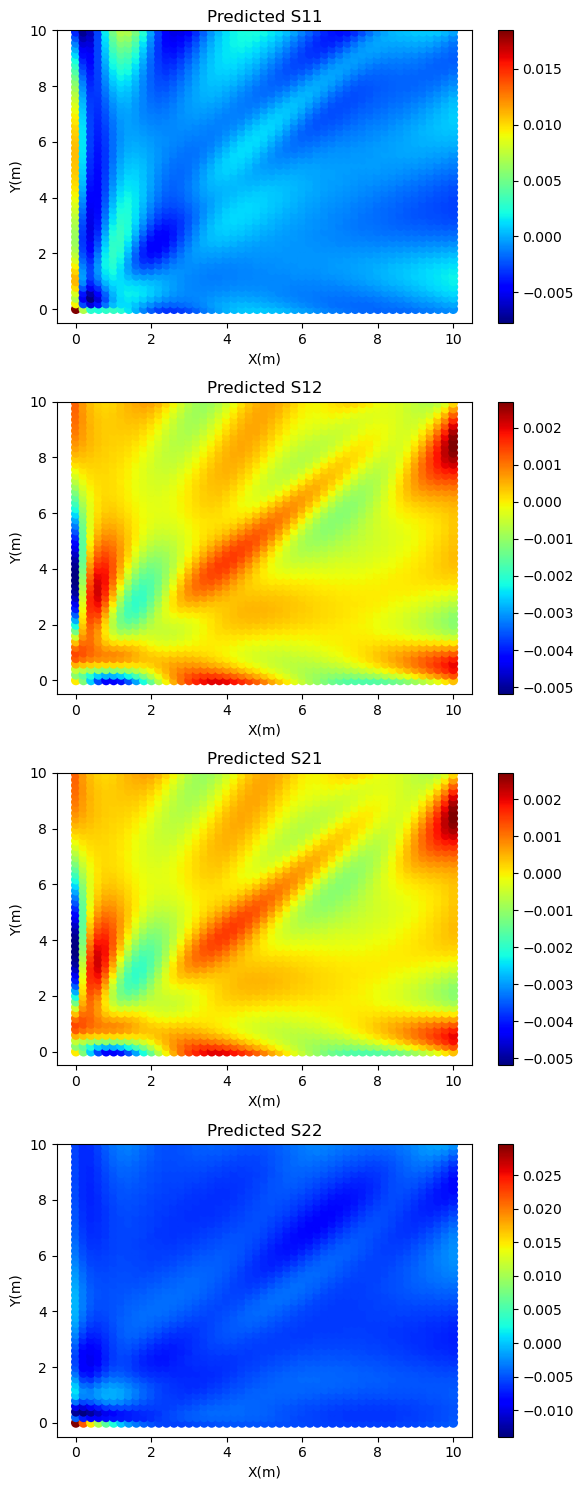

In [978]:
import matplotlib.pyplot as plt

# Assuming you have your X, Y, P11, P12, P21, and P22 defined

# Create a single figure
plt.figure(figsize=(6, 15))

# Subplot 1
plt.subplot(4, 1, 1)  # 4 rows, 1 column, subplot 1
scatter = plt.scatter(X.flatten(), Y.flatten(), c=S11, cmap='jet', s=50, edgecolors='k', linewidths=0.00005)
plt.ylim(None, ylimit)

plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.title('Predicted S11')
plt.colorbar(scatter)

# Subplot 2
plt.subplot(4, 1, 2)  # 4 rows, 1 column, subplot 2
scatter = plt.scatter(X.flatten(), Y.flatten(), c=S12, cmap='jet', s=50, edgecolors='k', linewidths=0.00005)
plt.ylim(None, ylimit)

plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.title('Predicted S12')
plt.colorbar(scatter)

# Subplot 3
plt.subplot(4, 1, 3)  # 4 rows, 1 column, subplot 3
scatter = plt.scatter(X.flatten(), Y.flatten(), c=S21, cmap='jet', s=50, edgecolors='k', linewidths=0.00005)
plt.ylim(None, ylimit)

plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.title('Predicted S21')
plt.colorbar(scatter)

# Subplot 4
plt.subplot(4, 1, 4)  # 4 rows, 1 column, subplot 4
#scatter = plt.scatter(X.flatten(), Y.flatten(), c=S22, cmap='jet', s=50, edgecolors='k', linewidths=0.00005,vmax=-0.1094,vmin=-0.1099)
scatter = plt.scatter(X.flatten(), Y.flatten(), c=S22, cmap='jet', s=50, edgecolors='k', linewidths=0.00005)
plt.ylim(None, ylimit)

plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.title('Predicted S22')
plt.colorbar(scatter)

# Adjust layout to prevent overlapping labels and titles
plt.tight_layout()

plt.show()  # Display the plot


In [979]:
import tensorflow as tf

# Example tensor with shape (2, 3, 4)
tensor = tf.constant([
    [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]],
    [[13, 14, 15, 16], [17, 18, 19, 20], [21, 22, 23, 24]]
])

# Define the permutation for the dimensions
# For example, to transpose from (2, 3, 4) to (4, 3, 2)
perm = [2, 1, 0]

# Transpose the tensor
transposed_tensor = tensor.transpose([0,1,2])

print(transposed_tensor.shape)

(2, 3, 4)


In [980]:
np.printoptions(limit=np.inf)